In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/model_att29iter_expanded.data-00000-of-00001
/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/input3.csv
/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/model_att29iter_expanded.index
/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/dialogs_expanded.csv
/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/target3.csv
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt


In [2]:
import re
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Concatenate
from keras.models import Model

# loading The Dataset

In [3]:
df= pd.read_csv('/kaggle/input/cleaned-data-for-the-chatbot-collected-from-movies/dialogs_expanded.csv', index_col=False)
df.head()

,Unnamed: 0,question,answer,question_as_int,answer_as_int,question_len,answer_len
0,1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,"[54, 67, 74, 74, 12, 1, 40, 1, 82, 70, 77, 83,...","[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...",71,55
1,2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,"[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...","[46, 73, 63, 87, 14, 14, 14, 1, 82, 70, 67, 76...",55,73
2,3,You're asking me out. That's so cute. What's ...,Forget it.,"[56, 77, 83, 8, 80, 67, 1, 63, 81, 73, 71, 76,...","[37, 77, 80, 69, 67, 82, 1, 71, 82, 14]",62,10
3,4,"No, no, it's my fault -- we didn't have a prop...",Cameron.,"[45, 77, 12, 1, 76, 77, 12, 1, 71, 82, 8, 81, ...","[34, 63, 75, 67, 80, 77, 76, 14]",65,8
4,9,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.,"[38, 77, 81, 70, 12, 1, 71, 68, 1, 77, 76, 74,...","[43, 67, 82, 1, 75, 67, 1, 81, 67, 67, 1, 85, ...",46,25


In [4]:
df.drop(['Unnamed: 0','question_as_int','answer_as_int','question_len','answer_len'],axis=1,inplace=True)

# Info about data 

In [5]:
print(df.shape)
print("="*60)
print(df.info())
print("="*60)
df.describe()

(139409, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139409 entries, 0 to 139408
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  139409 non-null  object
 1   answer    139409 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB
None


,question,answer
count,139409,139409
unique,127480,127605
top,I don't know.,I don't know.
freq,203,276


# Clean Data

In [6]:
df.drop_duplicates(subset=['question'],inplace=True)
df.describe()

,question,answer
count,127480,127480
unique,127480,117520
top,Make sure the Prince doesn't leave this room u...,I don't know.
freq,1,225


In [7]:
print(df.isnull().sum())
print('\n')
print(df.isnull().any())

question    0
answer      0
dtype: int64


question    False
answer      False
dtype: bool


In [8]:
df.loc[55:60,:]

,question,answer
55,No! You're not dating until your sister starts...,What if she never starts dating?
56,What if she never starts dating?,Then neither will you. And I'll get to sleep ...
57,Then neither will you. And I'll get to sleep ...,"But it's not fair -- she's a mutant, Daddy!"
58,But she doesn't want to date.,Exactly my point
59,"Daddy, I --",And where're you going?
60,And where're you going?,"If you must know, we were attempting to go to ..."


In [9]:
stop_words = set(stopwords.words('english'))
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def clean_text(text):
    text = text.lower()
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()])
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    text = re.sub(r'\d+', ' ', text)
    txt = re.sub(r"[^\w\s]", "", text)
    return text

In [10]:
df['encoder_input']=df['question'].apply(clean_text)
df['decoder_input']="<sos> " + df['answer'].apply(clean_text)
df['decoder_label'] = df['answer'].apply(clean_text) + ' eo>'
df.head()

,question,answer,encoder_input,decoder_input,decoder_label
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,well i thought we would start with pronunciat...,<sos> not the hacking and gagging and spitting...,not the hacking and gagging and spitting part ...
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,not the hacking and gagging and spitting part ...,<sos> okay then how bout we try out some f...,okay then how bout we try out some french ...
2,You're asking me out. That's so cute. What's ...,Forget it.,you are asking me out that is so cute what i...,<sos> forget it,forget it eo>
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.,no no it is my fault we did not have a pr...,<sos> cameron,cameron eo>
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.,gosh if only we could find kat a boyfriend,<sos> let me see what i can do,let me see what i can do eo>


In [11]:
encoder_input = np.array(df.question)
decoder_input = np.array(df.decoder_input)
decoder_label = np.array(df.decoder_label)

n_rows = df.shape[0]
print(f"{n_rows} rows")

indices = np.arange(n_rows)
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_label = decoder_label[indices]

train_size = 0.9

train_encoder_input = encoder_input[:int(n_rows*train_size)]
train_decoder_input = decoder_input[:int(n_rows*train_size)]
train_decoder_label = decoder_label[:int(n_rows*train_size)]

test_encoder_input = encoder_input[int(n_rows*train_size):]
test_decoder_input = decoder_input[int(n_rows*train_size):]
test_decoder_label = decoder_label[int(n_rows*train_size):]

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

127480 rows
(114732,)
(114732,)
(114732,)
(12748,)
(12748,)
(12748,)


# Tokens

In [12]:
q_tok = Tokenizer()
q_tok.fit_on_texts(train_encoder_input)
print(len(q_tok.word_counts))

a_tok = Tokenizer()
a_tok.fit_on_texts(train_decoder_input)
a_tok.fit_on_texts(train_decoder_label)
print(len(a_tok.word_counts))

train_encoder_input = q_tok.texts_to_sequences(train_encoder_input)
test_encoder_input = q_tok.texts_to_sequences(test_encoder_input)

train_decoder_input = a_tok.texts_to_sequences(train_decoder_input)
test_decoder_input = a_tok.texts_to_sequences(test_decoder_input)

train_decoder_label = a_tok.texts_to_sequences(train_decoder_label)
test_decoder_label = a_tok.texts_to_sequences(test_decoder_label)

question_word_size = len(q_tok.word_counts)
question_vocab_size = question_word_size+1

answer_word_size = len(a_tok.word_counts)
answer_vocab_size = answer_word_size+1

29962
25683


maximum question sequence length >> 25
maximum answer sequence length >> 31


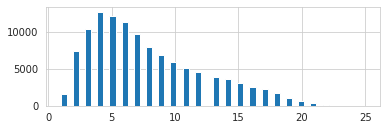

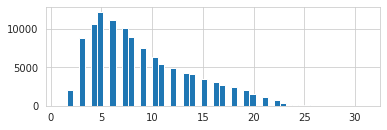

In [13]:
question_lengths = [len(s) for s in train_encoder_input]
print(f"maximum question sequence length >> {np.max(question_lengths)}")

answer_lengths = [len(s) for s in train_decoder_input]
print(f"maximum answer sequence length >> {np.max(answer_lengths)}")

plt.subplot(2,1,1)
plt.hist(question_lengths,bins=50)
plt.show()

plt.subplot(2,1,2)
plt.hist(answer_lengths,bins=50)
plt.show()

In [14]:
train_encoder_input = pad_sequences(train_encoder_input,padding='post')
train_decoder_input = pad_sequences(train_decoder_input,padding='post')
train_decoder_label = pad_sequences(train_decoder_label,padding='post')

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

question_sequence_size = train_encoder_input.shape[1]
answer_sequence_size = train_decoder_input.shape[1]

test_encoder_input = pad_sequences(test_encoder_input,padding='post',maxlen=question_sequence_size)
test_decoder_input = pad_sequences(test_decoder_input,padding='post',maxlen=answer_sequence_size)
test_decoder_label = pad_sequences(test_decoder_label,padding='post',maxlen=answer_sequence_size)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

(114732, 25)
(114732, 31)
(114732, 31)
(12748, 25)
(12748, 31)
(12748, 31)


# Glove Emdding

In [15]:
embedding_dict = dict()

f = open(os.path.join('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt'),encoding='utf-8')

for line in f:
    tokens = line.split()
    word = tokens[0]
    vector = tokens[1:]
    vector =  np.asarray(vector,dtype='float32')
    embedding_dict[word] = vector
    
f.close()

embedding_size = len(embedding_dict['world'])
print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"The size of embedding vector here >> {embedding_size}")

question_embedding_matrix =  np.zeros((question_vocab_size,embedding_size))
for word,idx in q_tok.word_index.items():
    if idx <= question_word_size:
        vector = embedding_dict.get(word)
        if vector is not None:
            question_embedding_matrix[idx] = np.asarray(vector,dtype='float32')

answer_embedding_matrix =  np.zeros((answer_vocab_size,embedding_size))
for word,idx in q_tok.word_index.items():
    if idx <= answer_word_size:
        vector = embedding_dict.get(word)
        if vector is not None:
            answer_embedding_matrix[idx] = np.asarray(vector,dtype='float32')

There are 400000 embedding vectors in total
The size of embedding vector here >> 50


In [16]:
def seq2question(encoder_input):
    ret=[q_tok.index_word[idx] for idx in encoder_input if idx != 0]
    return ' '.join(ret)

def seq2answer(decoder_input):
    ret = []
    for idx in decoder_input:
        if idx != 0:
            if a_tok.index_word[idx] != 'sos' and a_tok.index_word[idx] != 'eos':
                ret.append(a_tok.index_word[idx])
                
    return ' '.join(ret)

# Attention


In [17]:
import tensorflow
from tensorflow.keras.layers import Attention

# Model 

In [18]:
#trainer model

hidden_size = 256

#encoder part start
encoder_input = Input(shape=[question_sequence_size])
# encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[question_embedding_matrix])
encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)

lstm1 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output1,_,_= lstm1(encoder_embedded)
lstm2 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output2,_,_ = lstm2(encoder_output1)
lstm3 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output3,encoder_h3,encoder_c3= lstm3(encoder_output2)
#encoder part done

#decoder part start
decoder_input = Input(shape=(None,))
# decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[answer_embedding_matrix])
decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)

decoder_lstm = LSTM(hidden_size,return_sequences=True,return_state=True)
decoder_output,_,_ = decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])

#Attention layer (query,value)
attn_layer = Attention()
attention_context = attn_layer([decoder_output,encoder_output3])

decoder_output = Concatenate(axis=-1)([decoder_output,attention_context])

dense1 = Dense(512,activation='relu')
decoder_output = dense1(decoder_output)

decoder_softmax = Dense(answer_vocab_size,activation='softmax')
decoder_output = decoder_softmax(decoder_output)

trainer = Model([encoder_input,decoder_input],decoder_output)
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
trainer.compile(loss=loss,optimizer='adam',metrics=['accuracy'])
trainer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 50)       1498150     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 25, 256), (N 314368      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [19]:
train_hist = trainer.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=200,validation_split=0.1,batch_size=512)

Epoch 1/45
404/404 [==============================] - 242s 566ms/step - loss: 1.8840 - accuracy: 0.1248 - val_loss: 1.5505 - val_accuracy: 0.1653
Epoch 2/45
404/404 [==============================] - 226s 561ms/step - loss: 1.4942 - accuracy: 0.1822 - val_loss: 1.4541 - val_accuracy: 0.2088
Epoch 3/45
404/404 [==============================] - 227s 562ms/step - loss: 1.4048 - accuracy: 0.2136 - val_loss: 1.4227 - val_accuracy: 0.2174
Epoch 4/45
404/404 [==============================] - 227s 561ms/step - loss: 1.3603 - accuracy: 0.2207 - val_loss: 1.4065 - val_accuracy: 0.2230
Epoch 5/45
404/404 [==============================] - 227s 562ms/step - loss: 1.3273 - accuracy: 0.2273 - val_loss: 1.3983 - val_accuracy: 0.2265
Epoch 6/45
404/404 [==============================] - 227s 561ms/step - loss: 1.2930 - accuracy: 0.2323 - val_loss: 1.3950 - val_accuracy: 0.2290
Epoch 7/45
404/404 [==============================] - 228s 564ms/step - loss: 1.2712 - accuracy: 0.2371 - val_loss: 1.3965 -

In [20]:
#generator model
gen_encoder = Model(encoder_input,[encoder_output3,encoder_h3,encoder_c3])

gen_decoder_value_input = Input(shape=(question_sequence_size,hidden_size))
gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])

#attention([querys,values])
gen_attention_context = attn_layer([gen_decoder_output,gen_decoder_value_input])
gen_decoder_output = Concatenate(axis=-1)([gen_decoder_output,gen_attention_context])

gen_decoder_output = dense1(gen_decoder_output)
gen_decoder_output = decoder_softmax(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_value_input,gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])



In [21]:
def generate_from_input(encoder_input):
    values,h,c = gen_encoder.predict(encoder_input)
    
    decoder_seq = np.zeros((1,1))
    decoder_seq[0,0] = a_tok.word_index['sos']
    
    generated_sent = ''
    stop_condition= False
    
    while not stop_condition:
        output,h_state,c_state = gen_decoder.predict([decoder_seq]+[values,h,c])
        sampled_index = np.argmax(output[0,-1,:])
        sampled_word = a_tok.index_word[sampled_index]
        
        if sampled_word != 'eos':
            generated_sent = generated_sent + sampled_word + ' '
        
        if sampled_word == 'eos' or len(generated_sent) >= answer_sequence_size:
            stop_condition=True
        
        decoder_seq = np.zeros((1,1))
        decoder_seq[0,0] = sampled_index
        h,c = h_state,c_state
        
    return generated_sent.strip()

print(generate_from_input(train_encoder_input[24].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[1021].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[3001].reshape(1,question_sequence_size,-1)))

no i am not eo eo eo eo eo sports
i am not sure i am not eo eo eo
i am not sure i am not eo eo eo


# Test 

In [22]:
#results on train dataset
sample_indices= [5,26,7,11,735,662,115,321]

for idx in sample_indices:
    generated_sent = generate_from_input(train_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(train_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(train_decoder_input[idx])}")
    print("="*45)
    print("\n")

Question >> he's getting up
Answer(Generated) >> i am not sure i am not eo eo eo
Answer(Label) >> you cannot leave me then can you


Question >> it is now we're locked in
Answer(Generated) >> yeah i know what i am doing eo
Answer(Label) >> starck give me a read


Question >> i did what
Answer(Generated) >> i think you are the maxine winged
Answer(Label) >> as a matter of fact you came home without any clothes you were in your uh shorts yes sir


Question >> no you'll be marked for death
Answer(Generated) >> no problem eo eo eo clyde boys
Answer(Label) >> let me die then


Question >> i'm right behind you blue leader
Answer(Generated) >> i am not sure i am not going to
Answer(Label) >> what is that


Question >> gee mom do you think maybe he's a diamond smuggler
Answer(Generated) >> i am not sure i am going to be
Answer(Label) >> come on darling we are going up to bed


Question >> heavens look at that now
Answer(Generated) >> he is a little spoiled here eo
Answer(Label) >> i have seen 

In [23]:
#results on test dataset
sample_indices= [159,29,44,33]

for idx in sample_indices:
    generated_sent = generate_from_input(test_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(test_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(test_decoder_input[idx])}")
    print("="*45)
    print("\n")

Question >> don't do this send her a card something
Answer(Generated) >> i am not interested in th eo i
Answer(Label) >> we will make it


Question >> when i was very young
Answer(Generated) >> i do not know eo fermented grapes
Answer(Label) >> it seems like such a complicated game


Question >> i've got a responsibility here i can't let everybody grab free drinks
Answer(Generated) >> i am not going to be long eo eo
Answer(Label) >> what responsibility you are closing the fucking store to play hockey


Question >> it's amazing
Answer(Generated) >> i am not sure i am not afraid of
Answer(Label) >> i ve acted out my life on stages with ten thousand people watching


